<a href="https://colab.research.google.com/github/Karan-Katiyar/TensorFlow_Image_Classification_using_ResNEtV2_on_CIFAR/blob/main/TensorFlowResNetV2onCIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [2]:
# select tensorflow 2 in colab
%tensorflow_version 2.x

# install tensorflow 2 and tensorflow datasets on a personal machine
# !pip install tensorflow-gpu
# !pip install tensorflow-datasets

# tenorflow
import tensorflow as     tf
from   tensorflow import keras

# tensorflow datasets
import tensorflow_datasets as tfds

# additional libraries
import math
import numpy             as np
import matplotlib.pyplot as plt
# %matplotlib inline

# version check
# print(tf.__version__)

# Parameters

In [3]:
# data
DATA_NUM_CLASSES        = 10
DATA_CHANNELS           = 3
DATA_ROWS               = 32
DATA_COLS               = 32
DATA_CROP_ROWS          = 28
DATA_CROP_COLS          = 28
DATA_MEAN               = np.array([[[125.30691805, 122.95039414, 113.86538318]]]) # CIFAR10
DATA_STD_DEV            = np.array([[[ 62.99321928,  62.08870764,  66.70489964]]]) # CIFAR10

# model
MODEL_LEVEL_0_BLOCKS    = 4
MODEL_LEVEL_1_BLOCKS    = 6
MODEL_LEVEL_2_BLOCKS    = 3

# training
TRAINING_BATCH_SIZE      = 32
TRAINING_SHUFFLE_BUFFER  = 5000
TRAINING_BN_MOMENTUM     = 0.99
TRAINING_BN_EPSILON      = 0.001
TRAINING_LR_MAX          = 0.001
# TRAINING_LR_SCALE        = 0.1
# TRAINING_LR_EPOCHS       = 2
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 5
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 55

# training (derived)
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# saving
SAVE_MODEL_PATH = './save/model/'
!mkdir -p "$SAVE_MODEL_PATH"

# Data

In [4]:
# pre processing for training data
def pre_processing_train(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]
  
    # image is cast to float32, normalized, augmented and random cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[DATA_CROP_ROWS, DATA_CROP_COLS, 3])
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

# pre processing for testing data
def pre_processing_test(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]

    # image is cast to float32, normalized, augmented and center cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.crop_to_bounding_box(image, (DATA_ROWS - DATA_CROP_ROWS) // 2, (DATA_COLS - DATA_CROP_COLS) // 2, DATA_CROP_ROWS, DATA_CROP_COLS)
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

# download data and split into training and testing datasets
dataset_train, info = tfds.load("cifar10", split=tfds.Split.TRAIN, with_info=True)
dataset_test,  info = tfds.load("cifar10", split=tfds.Split.TEST,  with_info=True)

# debug - datasets
# print(dataset_train) # <_OptionsDataset shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
# print(dataset_test)  # <_OptionsDataset shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

# training data mean
# num_elem  = 0.0
# data_mean = np.array([0.0, 0.0, 0.0])
# for elem in dataset_train:
#     z         = np.copy(tf.dtypes.cast(elem["image"], tf.float32))
#     data_mean = data_mean + np.mean(z, axis=(0, 1))
#     num_elem  = num_elem + 1.0
# data_mean = data_mean/num_elem
# data_mean = data_mean.reshape(1, 1, 3)
# print(data_mean)

# training data std dev
# num_elem = 0.0
# data_std = np.array([0.0, 0.0, 0.0])
# for elem in dataset_train:
#     z        = np.copy(tf.dtypes.cast(elem["image"], tf.float32))
#     data_std = data_std + np.sum((z - data_mean)*(z - data_mean), axis=(0, 1))/float(DATA_ROWS*DATA_COLS)
#     num_elem = num_elem + 1.0
# data_std = data_std/num_elem
# data_std = np.sqrt(data_std)
# data_std = data_std.reshape(1, 1, 3)
# print(data_std)

# transform training dataset
dataset_train = dataset_train.map(pre_processing_train, num_parallel_calls=4)
dataset_train = dataset_train.shuffle(buffer_size=TRAINING_SHUFFLE_BUFFER)
dataset_train = dataset_train.batch(TRAINING_BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=1)

# transform testing dataset
dataset_test = dataset_test.map(pre_processing_test, num_parallel_calls=4)
dataset_test = dataset_test.batch(TRAINING_BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=1)

# debug - datasets after transformation
# print(dataset_train) # <PrefetchDataset shapes: ((None, 28, 28, 3), (None,)), types: (tf.float32, tf.int32)>
# print(dataset_test)  # <PrefetchDataset shapes: ((None, 28, 28, 3), (None,)), types: (tf.float32, tf.int32)>

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteW1E6QV/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteW1E6QV/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


# Model

Model: "resnetv2_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   864         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 28, 28, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________________

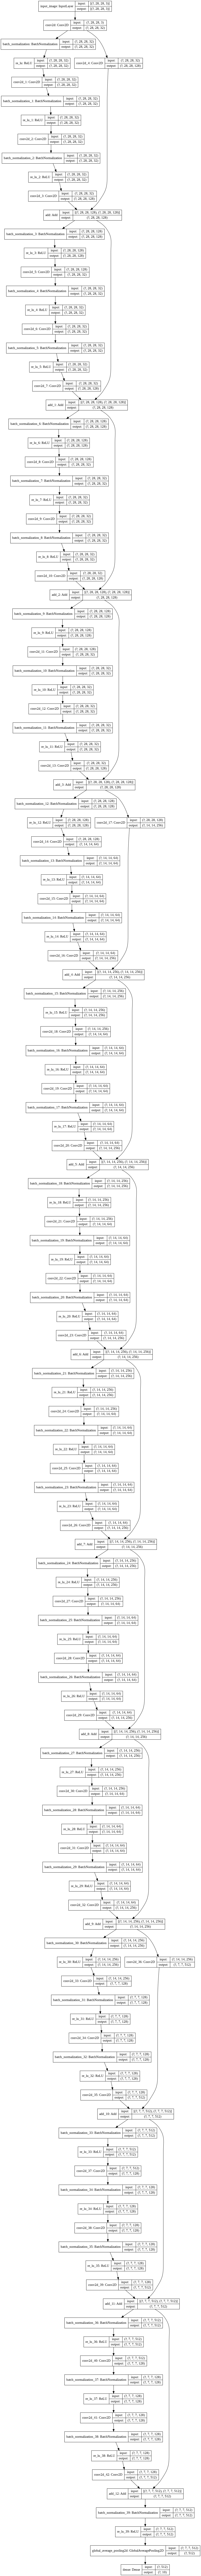

In [5]:
# create and compile model
def create_model(rows, cols, channels, level_0_blocks, level_1_blocks, level_2_blocks, num_classes, lr_initial):

    # encoder - input
    model_input = keras.Input(shape=(rows, cols, channels), name='input_image')
    x           = model_input
    
    # encoder - tail
    x = keras.layers.Conv2D(32, 3, strides=1, padding='same', activation=None, use_bias=False)(x)

    # encoder - level 0 - special bottleneck - repeat 1x
    # input
    #    tensor: 28 x 28 x 32
    # residual path
    #    filter:  32 x 1 x 1 x 32
    #    filter:  32 x 3 x 3 x 32
    #    filter: 128 x 1 x 1 x 32
    # main path
    #    filter: 128 x 1 x 1 x 32
    # output
    #    tensor: 28 x 28 x 128
    residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual = keras.layers.ReLU()(residual)
    residual = keras.layers.Conv2D(32, 1, strides=1, padding='same', activation=None, use_bias=False)(residual)
    residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
    residual = keras.layers.ReLU()(residual)
    residual = keras.layers.Conv2D(32, 3, strides=1, padding='same', activation=None, use_bias=False)(residual)
    residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
    residual = keras.layers.ReLU()(residual)
    residual = keras.layers.Conv2D(128, 1, strides=1, padding='same', activation=None, use_bias=False)(residual)
    x        = keras.layers.Conv2D(128, 1, strides=1, padding='same', activation=None, use_bias=False)(x)
    x        = keras.layers.Add()([x, residual])

    # encoder - level 0 - standard bottleneck - repeat (level_0_blocks - 1)x
    # input
    #    tensor:  28 x 28 x 128
    # residual path
    #    filter:  32 x 1 x 1 x 128
    #    filter:  32 x 3 x 3 x  32
    #    filter: 128 x 1 x 1 x  32
    # main path
    #    filter: identity
    # output
    #    tensor: 28 x 28 x 128
    for n0 in range(level_0_blocks - 1):
        residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
        residual = keras.layers.ReLU()(residual)
        residual = keras.layers.Conv2D(32, 1, strides=1, padding='same', activation=None, use_bias=False)(residual)
        residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
        residual = keras.layers.ReLU()(residual)
        residual = keras.layers.Conv2D(32, 3, strides=1, padding='same', activation=None, use_bias=False)(residual)
        residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
        residual = keras.layers.ReLU()(residual)
        residual = keras.layers.Conv2D(128, 1, strides=1, padding='same', activation=None, use_bias=False)(residual)
        x        = keras.layers.Add()([x, residual])

    # encoder - level 1 - down sampling bottleneck - repeat 1x
    # input
    #    tensor:  28 x 28 x 128
    # residual path
    #    filter:  64 x 1 x 1 x 128 / 2
    #    filter:  64 x 3 x 3 x 64
    #    filter: 256 x 1 x 1 x 64
    # main path
    #    filter: 256 x 1 x 1 x 128 / 2
    # output
    #    tensor:  14 x 14 x 256
    residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual = keras.layers.ReLU()(residual)
    residual = keras.layers.Conv2D(64, 1, strides=2, padding='same', activation=None, use_bias=False)(residual)
    residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
    residual = keras.layers.ReLU()(residual)
    residual = keras.layers.Conv2D(64, 3, strides=1, padding='same', activation=None, use_bias=False)(residual)
    residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
    residual = keras.layers.ReLU()(residual)
    residual = keras.layers.Conv2D(256, 1, strides=1, padding='same', activation=None, use_bias=False)(residual)
    x        = keras.layers.Conv2D(256, 1, strides=2, padding='same', activation=None, use_bias=False)(x)
    x        = keras.layers.Add()([x, residual])

    # encoder - level 1 - standard bottleneck - repeat (level_1_blocks - 1)x
    # input
    #    tensor:  14 x 14 x 256
    # residual path
    #    filter:  64 x 1 x 1 x 256
    #    filter:  64 x 3 x 3 x 64
    #    filter: 256 x 1 x 1 x 64
    # main path
    #    filter: identity
    # output
    #    tensor:  14 x 14 x 256
    for n1 in range(level_1_blocks - 1):
        residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
        residual = keras.layers.ReLU()(residual)
        residual = keras.layers.Conv2D(64, 1, strides=1, padding='same', activation=None, use_bias=False)(residual)
        residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
        residual = keras.layers.ReLU()(residual)
        residual = keras.layers.Conv2D(64, 3, strides=1, padding='same', activation=None, use_bias=False)(residual)
        residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
        residual = keras.layers.ReLU()(residual)
        residual = keras.layers.Conv2D(256, 1, strides=1, padding='same', activation=None, use_bias=False)(residual)
        x        = keras.layers.Add()([x, residual])

    # encoder - level 2 - down sampling bottleneck - repeat 1x
    # input
    #    tensor:  14 x 14 x 256
    # residual path
    #    filter: 128 x 1 x 1 x 256 / 2
    #    filter: 128 x 3 x 3 x 128
    #    filter: 512 x 1 x 1 x 128
    # main path
    #    filter: 512 x 1 x 1 x 256 / 2
    # output
    #    tensor:   7 x 7 x 512
    residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    residual = keras.layers.ReLU()(residual)
    residual = keras.layers.Conv2D(128, 1, strides=2, padding='same', activation=None, use_bias=False)(residual)
    residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
    residual = keras.layers.ReLU()(residual)
    residual = keras.layers.Conv2D(128, 3, strides=1, padding='same', activation=None, use_bias=False)(residual)
    residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
    residual = keras.layers.ReLU()(residual)
    residual = keras.layers.Conv2D(512, 1, strides=1, padding='same', activation=None, use_bias=False)(residual)
    x        = keras.layers.Conv2D(512, 1, strides=2, padding='same', activation=None, use_bias=False)(x)
    x        = keras.layers.Add()([x, residual])

    # encoder - level 2 - standard bottleneck - repeat (level_2_blocks - 1)x
    # input
    #    tensor:   7 x 7 x 512
    # residual path
    #    filter: 128 x 1 x 1 x 512
    #    filter: 128 x 3 x 3 x 128
    #    filter: 512 x 1 x 1 x 128
    # main path
    #    filter: identity
    # output
    #    tensor:   7 x 7 x 512
    for n2 in range(level_2_blocks - 1):
        residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
        residual = keras.layers.ReLU()(residual)
        residual = keras.layers.Conv2D(128, 1, strides=1, padding='same', activation=None, use_bias=False)(residual)
        residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
        residual = keras.layers.ReLU()(residual)
        residual = keras.layers.Conv2D(128, 3, strides=1, padding='same', activation=None, use_bias=False)(residual)
        residual = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(residual)
        residual = keras.layers.ReLU()(residual)
        residual = keras.layers.Conv2D(512, 1, strides=1, padding='same', activation=None, use_bias=False)(residual)
        x        = keras.layers.Add()([x, residual])

    # encoder - level 2 - standard bottleneck complete
    # input
    #    tensor:   7 x 7 x 512
    # main path
    #    batch norm
    #    ReLU
    # output
    #    tensor:   7 x 7 x 512
    x = keras.layers.BatchNormalization(axis=-1, momentum=TRAINING_BN_MOMENTUM, epsilon=TRAINING_BN_EPSILON, center=True, scale=True)(x)
    x = keras.layers.ReLU()(x)

    # encoder - output
    encoder_output = x

    # decoder
    y              = keras.layers.GlobalAveragePooling2D()(encoder_output)
    decoder_output = keras.layers.Dense(num_classes, activation='softmax')(y)

    # forward path
    model = keras.Model(inputs=model_input, outputs=decoder_output, name='resnetv2_model')

    # loss, backward path (implicit) and weight update
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_initial), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # return model
    return model

# create and compile model
model = create_model(DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS, MODEL_LEVEL_0_BLOCKS, MODEL_LEVEL_1_BLOCKS, MODEL_LEVEL_2_BLOCKS, DATA_NUM_CLASSES, TRAINING_LR_MAX)

# model description and figure
model.summary()
keras.utils.plot_model(model, 'cifar_model.png', show_shapes=True)

# Train and Validate

Epoch 1/60
1563/1563 [==============================] - ETA: 0s - loss: 1.9443 - accuracy: 0.2954
Epoch 00001: val_loss improved from inf to 1.69336, saving model to ./save/model/model_1.h5
1563/1563 [==============================] - 55s 35ms/step - loss: 1.9443 - accuracy: 0.2954 - val_loss: 1.6934 - val_accuracy: 0.3892
Epoch 2/60
1563/1563 [==============================] - ETA: 0s - loss: 1.3516 - accuracy: 0.5097
Epoch 00002: val_loss improved from 1.69336 to 1.16751, saving model to ./save/model/model_2.h5
1563/1563 [==============================] - 54s 35ms/step - loss: 1.3516 - accuracy: 0.5097 - val_loss: 1.1675 - val_accuracy: 0.5781
Epoch 3/60
1563/1563 [==============================] - ETA: 0s - loss: 1.0495 - accuracy: 0.6299
Epoch 00003: val_loss improved from 1.16751 to 1.00863, saving model to ./save/model/model_3.h5
1563/1563 [==============================] - 54s 35ms/step - loss: 1.0495 - accuracy: 0.6299 - val_loss: 1.0086 - val_accuracy: 0.6366
Epoch 4/60
1563/1

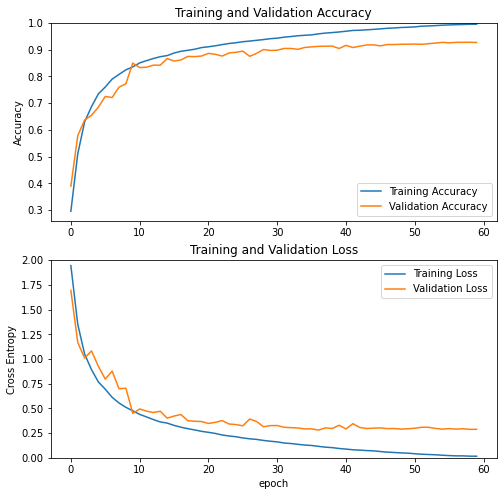

In [6]:
# learning rate schedule
def lr_schedule(epoch):

    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))

    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)*max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + TRAINING_LR_FINAL

    # debug - learning rate display
    # print(epoch)
    # print(lr)

    return lr

# plot training accuracy and loss curves
def plot_training_curves(history):

    # training and validation data accuracy
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # training and validation data loss
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    # plot accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    # plot loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# callbacks (learning rate schedule, model checkpointing during training)
callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule),
             keras.callbacks.ModelCheckpoint(filepath=SAVE_MODEL_PATH+'model_{epoch}.h5', save_best_only=True, monitor='val_loss', verbose=1)]

# training
initial_epoch_num = 0
history           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

# example of restarting training after a crash from the last saved checkpoint
# model             = create_model(MODEL_LEVEL_0_REPEATS, MODEL_LEVEL_1_REPEATS, MODEL_LEVEL_2_REPEATS)
# model.load_weights(SAVE_MODEL_PATH+'model_X.h5') # replace X with the last saved checkpoint number
# initial_epoch_num = X                            # replace X with the last saved checkpoint number
# history           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

# plot accuracy and loss curves
plot_training_curves(history)

# Test

In [7]:
test_loss, test_accuracy = model.evaluate(x=dataset_test)
print('Test loss:     ', test_loss)
print('Test accuracy: ', test_accuracy)

# example of saving and loading the model in Keras H5 format
# this saves both the model and the weights
# model.save('./save/model/model.h5')
# new_model       = keras.models.load_model('./save/model/model.h5')
# predictions     = model.predict(x=dataset_test)
# new_predictions = new_model.predict(x=dataset_test)
# np.testing.assert_allclose(predictions, new_predictions, atol=1e-6)

# example of saving and loading the model in TensorFlow SavedModel format
# this saves both the model and the weights
# keras.experimental.export_saved_model(model, './save/model/')
# new_model       = keras.experimental.load_from_saved_model('./save/model/')
# predictions     = model.predict(x=dataset_test)
# new_predictions = new_model.predict(x=dataset_test)
# np.testing.assert_allclose(predictions, new_predictions, atol=1e-6)

# example of getting a list of all feature maps
# feature_map_list = [layer.output for layer in model.layers]
# print(feature_map_list)

# example of creating a model encoder
# replace X with the layer number of the encoder output
# model_encoder    = keras.Model(inputs=model.input, outputs=model.layers[X].output)
# model_encoder.summary()

313/313 [==============================] - 3s 9ms/step - loss: 0.2880 - accuracy: 0.9268
Test loss:      0.2879713475704193
Test accuracy:  0.926800012588501


# Display

Predicted label: 7 and actual label: 7


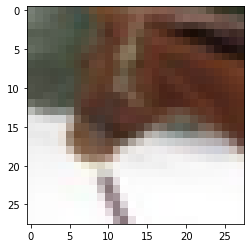

Predicted label: 0 and actual label: 0


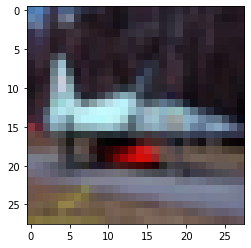

Predicted label: 6 and actual label: 6


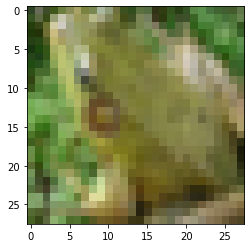

Predicted label: 9 and actual label: 9


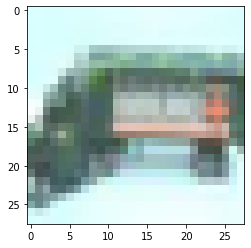

Predicted label: 7 and actual label: 5


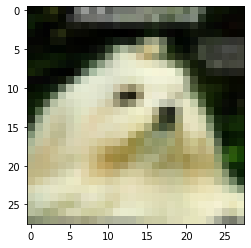

Predicted label: 1 and actual label: 1


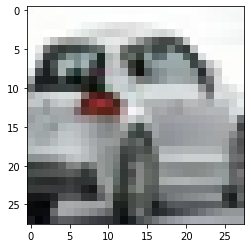

Predicted label: 7 and actual label: 7


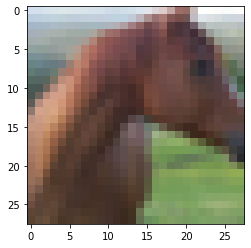

Predicted label: 0 and actual label: 0


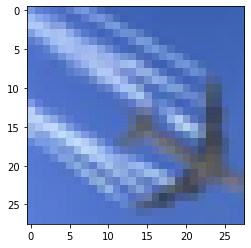

Predicted label: 5 and actual label: 3


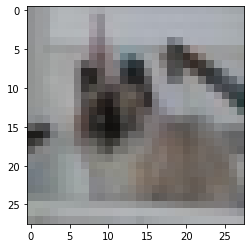

Predicted label: 2 and actual label: 2


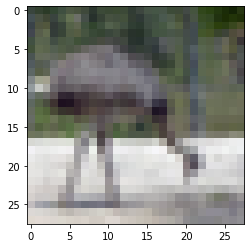

Predicted label: 7 and actual label: 7


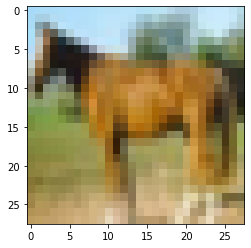

Predicted label: 2 and actual label: 2


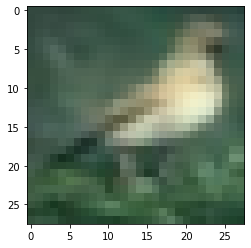

Predicted label: 7 and actual label: 7


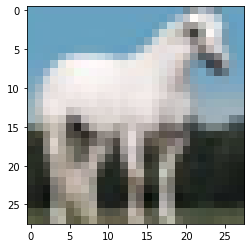

Predicted label: 9 and actual label: 9


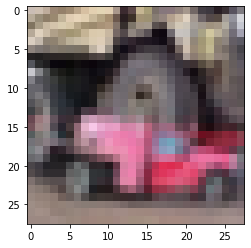

Predicted label: 7 and actual label: 6


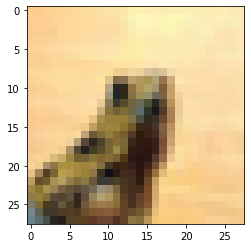

Predicted label: 8 and actual label: 8


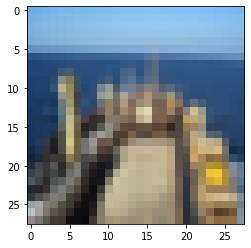

Predicted label: 8 and actual label: 8


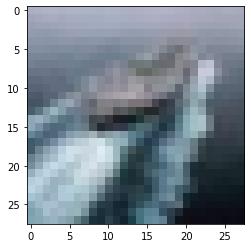

Predicted label: 8 and actual label: 8


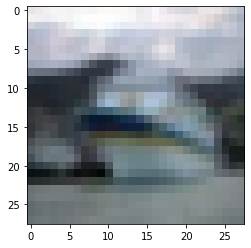

Predicted label: 7 and actual label: 7


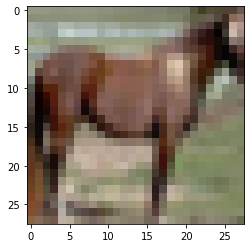

Predicted label: 9 and actual label: 9


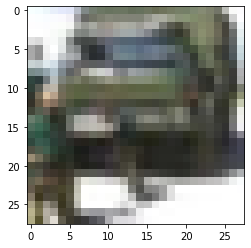

Predicted label: 4 and actual label: 4


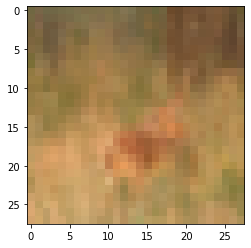

Predicted label: 2 and actual label: 2


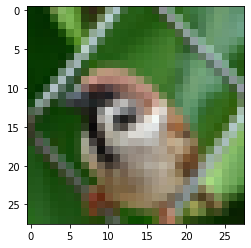

Predicted label: 3 and actual label: 3


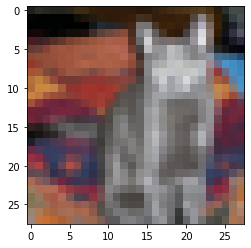

Predicted label: 5 and actual label: 5


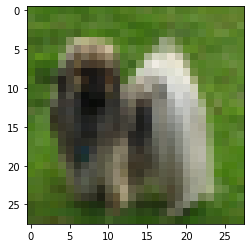

Predicted label: 0 and actual label: 0


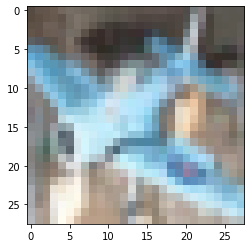

Predicted label: 0 and actual label: 0


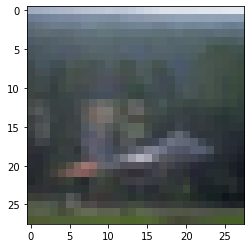

Predicted label: 2 and actual label: 2


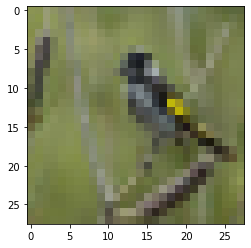

Predicted label: 8 and actual label: 8


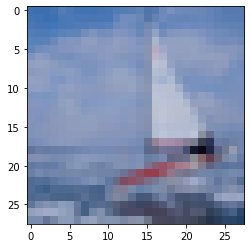

Predicted label: 1 and actual label: 1


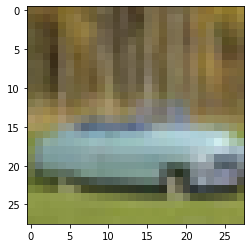

Predicted label: 8 and actual label: 8


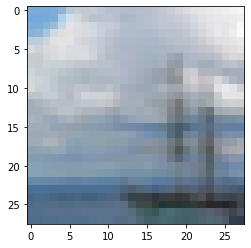

Predicted label: 2 and actual label: 2


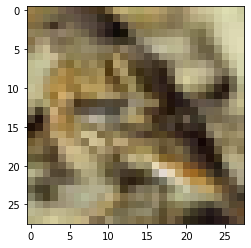

Predicted label: 0 and actual label: 0


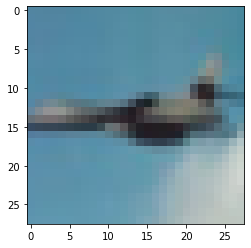

In [8]:
# extract a batch from the testing dataset
# then extract images and labels for this batch
dataset_display                = dataset_test.take(1)
it                             = iter(dataset_display)
display_images, display_labels = next(it)

# predict pmf and labels for this dataset
predict_labels_pmf = model.predict(x=dataset_display)
predict_labels     = np.argmax(predict_labels_pmf, axis=1)

# for display normalize images to [0, 1]
display_images = ((display_images*DATA_STD_DEV.reshape((1, 1, 1, 3))) + DATA_MEAN.reshape((1, 1, 1, 3)))/255.0;

# cycle through the images in the batch
for image_index in range(predict_labels.size):
    
    # display the predicted label, actual label and image
    print('Predicted label: {0:1d} and actual label: {1:1d}'.format(predict_labels[image_index], display_labels[image_index]))
    plt.imshow(display_images[image_index, :, :, :])
    plt.show()